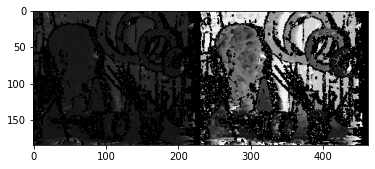

<Figure size 432x288 with 0 Axes>

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dmax=30   #搜寻匹配的范围
window_size=2  #匹配窗大小
f=30 #焦距
T=20 #两个相机间距
alpha=1 #阈值ve的系数


left=cv2.imread('left.png')
right=cv2.imread('right.png')
#print(left.shape,right.shape)
size1,size2=left.shape[0],left.shape[1]

disparity=np.zeros((size1,size2), dtype=np.uint8)
#error_energy
e=np.zeros_like(disparity)
e_avg=np.ones_like(disparity)
e_avg=e_avg*100000

for d in range(dmax):
    ##先计算  e （i,j，d）
    for i in range(size1):
        for j in range(size2):
            sum =0
            for m in range(window_size):
                for n in range(window_size):
                    for k in range(3):
                        x=min(size1-1,i+m)
                        y=min(size2-1,j+n)
                        square_diff=(int(left[x][min(y+d,size2-1)][k])-int(right[x][y][k]))**2
                        sum=sum+square_diff
            e[i][j]=sum/(3*window_size*window_size)

    ##再计算e_avg（i,j，d）
    for i in range(size1):
        for j in range(size2):
            e_temp = 0
            for m in range(window_size):
                for n in range(window_size):
                    x = min(size1-1, i + m)
                    y = min(size2-1, j + n)
                    e_temp=e_temp+e[x][y]
            e_temp=e_temp/(window_size*window_size)
            if e_temp<e_avg[i,j]:
                e_avg[i,j]=e_temp
                disparity[i,j]=d
ve=alpha*e_avg.mean()#设定可靠度阈值ve
count_not_ne=0
sum_e=0
for i in range(size1):
    for j in range(size2):
        if e_avg[i][j]>ve:
            disparity[i][j]=0
        else:
            sum_e=sum_e+e_avg[i][j]
            count_not_ne=count_not_ne+1
# reliability=float(count_not_ne)**(-1)*sum_e

depth=np.ones_like(disparity,dtype=np.uint8)
for i in range(size1):
    for j in range(size2):
        if disparity[i][j]<5: ##噪音
            depth[i][j]=0
        else:
            depth[i][j]=f*T//disparity[i][j]


cv2.medianBlur(depth,3)

cv2.imwrite('depth_reliable_medianblur.png', depth)
#######增强对比度显示
temp=cv2.imread('depth_reliable_medianblur.png')
gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY) #opencv的直方图均衡化要基于单通道灰度图像
dist = cv2.equalizeHist(gray)
cv2.imwrite('Stereo_Matching_base_intensity.png', dist)
temp2=cv2.imread('Stereo_Matching_base_intensity.png')
plt.imshow(np.hstack([temp,temp2])),plt.show()


X=range(size1)
Y=range(size2)
Z=depth
xx, yy=np.meshgrid(X, Y)#网格化坐标
X, Y=xx.ravel(), yy.ravel()#矩阵扁平化
bottom=np.zeros_like(X)#设置柱状图的底端位值
Z=Z.ravel()#扁平化矩阵

width=height=1#每一个柱子的长和宽

fig=plt.figure()